## Dataset: CGMacros: a scientific dataset for personalized nutrition and diet monitoring.
#### Objective: Uncover meaningful relationships between dietary habits,glucose responses, physical activity, and gut health.
#### Implementing Machine Learning Approach to Predict 2-hour Post Meal Glucose Levels.
   - In Sprint 1, we prepared and cleaned the merged datasets (CGMacros, Bio, Gut Health, Microbes).
   - In Sprint 2, we derived insights from the cleaned datasets through visualizations.
      -  We also implemented machine learning approach by selecting relevant features and split the data into training and test sets.
      -  We then applied multiple regression models to predict 2-hour post-meal glucose levels from two CGM devices: Libre and Dexcom.
   - Benefits of using ML for glucose prediction:
      -  ML models can help identify individuals at high risk of prediabetes and, in turn, developing type 2 diabetes. Early identification allows for targeted interventions to prevent or delay the onset of the disease.
      -  By identifying patterns in this data, the algorithms can predict future glucose levels, allowing individuals and their healthcare providers to proactively manage blood sugar and prevent potentially harmful highs and lows.
      -  In essence, using machine learning for post-meal glucose prediction is a way to leverage technology to gain a deeper understanding of how our bodies respond to food and use that knowledge to make informed decisions that promote better health and well-being, regardless of whether someone has diabetes, prediabetes, or is considered healthy. 

### Import Libraries

In [4]:
#! pip install xgboost

In [6]:
import os
import pandas as pd
import numpy as np

import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

warnings.filterwarnings("ignore", category=UserWarning)
from datetime import timedelta

### Read the cleaned csv files

In [9]:
merged_df = pd.read_csv('02DataExplorers_Cleaned_Merged_Participants_Data.csv')
participant_details_df = pd.read_csv('02DataExplorers_Cleaned_MergedBioGuthealthMicrobesData.csv')

In [10]:
# Convert datatypes of data,time and timestamp columns from object to datetime
merged_df['Timestamp'] = pd.to_datetime(merged_df['Timestamp'])

In [11]:
merged_df.head()

,ParticipantID,Timestamp,Date,Time,Libre_GL,Dexcom_GL,Heart_Rate,Activity_Calories_Per_Minute,METs,Meal_Type,Meal_Calories,Carbs,Protein,Fat,Fiber,Amount_Consumed(%),Image_Path
0,1,2020-05-01 10:30:00,2020-05-01,10:30,84.00,106.83,56.0,1.05,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2020-05-01 10:31:00,2020-05-01,10:31,84.13,106.83,56.0,1.05,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-05-01 10:32:00,2020-05-01,10:32,84.27,106.83,57.0,1.05,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-05-01 10:33:00,2020-05-01,10:33,84.40,106.83,54.0,1.05,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2020-05-01 10:34:00,2020-05-01,10:34,84.53,106.83,55.0,1.05,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#merged_df.dtypes

In [13]:
participant_details_df.head()

,ParticipantID,Age,Gender,BMI,BMI_Classification,Weight,Height,Ethnicity,HbA1c,HbA1c_Classification,...,Sulfide_Gas_Production_Pathways_Desc,Oxalate_Metabolism_Pathways,Oxalate_Metabolism_Pathways_Desc,Salt_Stress_Pathways,Salt_Stress_Pathways_Desc,Microbiome_Induced_Stress,Microbiome_Induced_Stress_Desc,Good_Microbes_Count,Moderate_Microbes_Count,Bad_Microbes_Count
0,1,27,M,22.27,Normal,133.8,65.0,Hispanic/Latino,5.4,Normal,...,Not Optimal,1.0,Not Optimal,3.0,Good,2.0,Average,87,435,15
1,2,49,F,30.95,Obese,169.2,62.0,Hispanic/Latino,5.5,Normal,...,Not Optimal,3.0,Good,2.0,Average,1.0,Not Optimal,42,377,30
2,3,59,F,26.95,Overweight,157.0,64.0,Hispanic/Latino,6.5,Diabetes,...,Average,1.0,Not Optimal,3.0,Good,2.0,Average,62,409,27
3,4,33,F,42.38,Obese,262.6,66.0,Hispanic/Latino,5.5,Normal,...,Good,1.0,Not Optimal,2.0,Average,2.0,Average,53,328,26
4,5,51,F,30.96,Obese,172.0,62.5,Hispanic/Latino,6.6,Diabetes,...,Average,2.0,Average,2.0,Average,2.0,Average,23,292,27


### Data Visualization

In [20]:
# Import all Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import altair as alt    
from IPython.display import display,HTML
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#### Checking the average glucose change post 2 hour meal for Libre and Dexcom monitors

In [23]:
# Ensure datetime conversion once
merged_df['Time'] = pd.to_datetime(merged_df['Timestamp'])

# Filter only meal rows (non-zero meal calories)
meal_df = merged_df[merged_df['Meal_Calories'] > 0].copy()
meal_df = meal_df.sort_values(by=['ParticipantID', 'Time']) 
meal_df.head()

,ParticipantID,Timestamp,Date,Time,Libre_GL,Dexcom_GL,Heart_Rate,Activity_Calories_Per_Minute,METs,Meal_Type,Meal_Calories,Carbs,Protein,Fat,Fiber,Amount_Consumed(%),Image_Path
233,1,2020-05-01 14:23:00,2020-05-01,2020-05-01 14:23:00,69.8,109.4,95.0,4.61,44.0,Lunch,1170.0,85.0,88.0,54.2,12.0,100.0,photos/00000005-PHOTO-2020-5-1-14-23-0.jpg
618,1,2020-05-01 20:48:00,2020-05-01,2020-05-01 20:48:00,84.8,114.8,81.0,1.36,13.0,Dinner,80.0,18.0,0.0,0.0,0.0,100.0,photos/00000007-PHOTO-2020-5-1-20-48-0.jpg
825,1,2020-05-02 00:15:00,2020-05-02,2020-05-02 00:15:00,81.0,97.4,78.0,4.40,42.0,Snack,110.0,24.0,0.0,2.0,0.0,100.0,NaN
1308,1,2020-05-02 08:18:00,2020-05-02,2020-05-02 08:18:00,88.4,101.8,81.0,3.15,30.0,Breakfast,448.0,66.0,22.0,10.5,0.0,100.0,photos/00000010-PHOTO-2020-5-2-8-18-0.jpg
1530,1,2020-05-02 12:00:00,2020-05-02,2020-05-02 12:00:00,82.0,80.0,84.0,2.94,28.0,Lunch,840.0,89.0,17.0,42.0,3.0,100.0,photos/00000012-PHOTO-2020-5-2-12-0-0.jpg


#### Libre_GL Monitor

In [25]:
# Group merged data by participant once
grouped = merged_df.groupby('ParticipantID')

glucose_changes1 = []

for index, meal in meal_df.iterrows():
    pid = meal['ParticipantID']
    meal_time = meal['Time']  # Already datetime

    # Get only this participant's data once
    participant_data = grouped.get_group(pid)

    # Use boolean masks for filtering within 2-hour window
    post_meal_mask = (participant_data['Time'] > meal_time) & \
                     (participant_data['Time'] <= meal_time + timedelta(hours = 2))
    pre_meal_mask = participant_data['Time'] <= meal_time

    post_meal_gl = participant_data.loc[post_meal_mask, 'Libre_GL']
    pre_meal_gl = participant_data.loc[pre_meal_mask].sort_values(by='Time', ascending=False)['Libre_GL']

    if not post_meal_gl.empty and not pre_meal_gl.empty:
        glucose_changes1.append({
            'ParticipantID': pid,
            'Meal_Type': meal['Meal_Type'],
            'Meal_Time': meal_time,
            'Pre_Meal_Glucose_libre': pre_meal_gl.iloc[0],
            'Post_Meal_Avg_Glucose_libre': post_meal_gl.mean(),
            'Glucose_Change_libre': post_meal_gl.mean() - pre_meal_gl.iloc[0]
        })

# Convert results to DataFrame
glucose_change_df_libre = pd.DataFrame(glucose_changes1)

In [22]:
#glucose_change_df_libre.shape #(1661, 6)

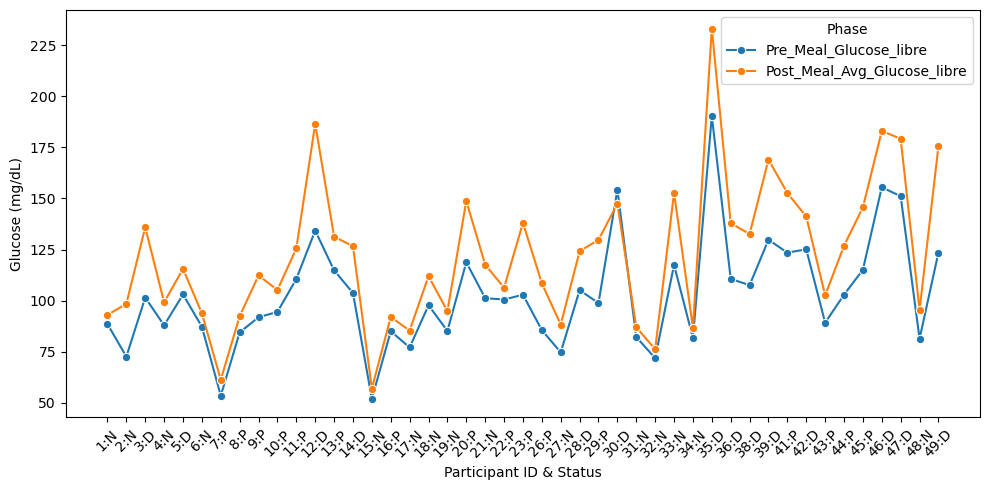

In [26]:
# Reshape the data 
melted_df1 = pd.melt(
    glucose_change_df_libre,
    id_vars=['ParticipantID'],
    value_vars=['Pre_Meal_Glucose_libre', 'Post_Meal_Avg_Glucose_libre'],
    var_name='Phase',
    value_name='Glucose'
)

# Merge Diabetesstatus(HbA1c_Classification) column
melted_df1 = melted_df1.merge(participant_details_df[['ParticipantID', 'HbA1c_Classification']], on='ParticipantID')

# Create x-axis labels with ID and first letter of diabetes status
melted_df1['label'] = melted_df1['ParticipantID'].astype(str) + ':' + melted_df1['HbA1c_Classification'].str[0]

# Plot using label as x-axis
plt.figure(figsize=(10,5))
sns.lineplot(data=melted_df1, x='label', y='Glucose', hue='Phase', marker='o', ci =None)

#plt.title('Pre- vs Post-Meal Glucose levels per Participant with Diabetes Status - Libre')
plt.xticks(rotation=45)
plt.ylabel('Glucose (mg/dL)')
plt.xlabel('Participant ID & Status')
#plt.grid(True)
plt.tight_layout()
plt.show()

#### Libre - Insights:
- Post-meal glucose levels again rise notably, with peaks around 200-225 mg/dL for participant 35 who is diabetic.
- Diabetic participants consistently show higher post-meal levels, while normal (N) participants generally maintain lower levels, though some prediabetic (P) cases show intermediate responses.
- Outliers: Some normal (N) and prediabetic (P) participants also showed elevated post-meal levels, indicating potential early signs of glucose dysregulation.

#### Dexcom_GL Monitor

In [29]:
# Group merged data by participant once
grouped = merged_df.groupby('ParticipantID')

glucose_changes2 = []

for index, meal in meal_df.iterrows():
    pid = meal['ParticipantID']
    meal_time = meal['Timestamp']  # Already datetime

    # Get only this participant's data once
    participant_data = grouped.get_group(pid)

    # Use boolean masks for filtering within 2-hour window
    post_meal_mask = (participant_data['Time'] > meal_time) & \
                     (participant_data['Time'] <= meal_time + timedelta(hours= 2))
    pre_meal_mask = participant_data['Time'] <= meal_time

    post_meal_gl = participant_data.loc[post_meal_mask, 'Dexcom_GL']
    pre_meal_gl = participant_data.loc[pre_meal_mask].sort_values(by='Time', ascending=False)['Dexcom_GL']

    if not post_meal_gl.empty and not pre_meal_gl.empty:
        glucose_changes2.append({
            'ParticipantID': pid,
            'Meal_Type': meal['Meal_Type'],
            'Meal_Time': meal_time,
            'Pre_Meal_Glucose_Dexcom': pre_meal_gl.iloc[0],
            'Post_Meal_Avg_Glucose_Dexcom': post_meal_gl.mean(),
            'Glucose_Change_Dexcom': post_meal_gl.mean() - pre_meal_gl.iloc[0]
        })

# Convert results to DataFrame
glucose_change_df_dexcom = pd.DataFrame(glucose_changes2)
glucose_change_df_dexcom.head()

,ParticipantID,Meal_Type,Meal_Time,Pre_Meal_Glucose_Dexcom,Post_Meal_Avg_Glucose_Dexcom,Glucose_Change_Dexcom
0,1,Lunch,2020-05-01 14:23:00,109.4,115.516667,6.116667
1,1,Dinner,2020-05-01 20:48:00,114.8,126.658333,11.858333
2,1,Snack,2020-05-02 00:15:00,97.4,112.951667,15.551667
3,1,Breakfast,2020-05-02 08:18:00,101.8,109.675000,7.875000
4,1,Lunch,2020-05-02 12:00:00,80.0,87.961667,7.961667


In [30]:
#glucose_change_df_dexcom.shape #(1661, 6)

In [31]:
# Reshape the data 
melted_df2 = pd.melt(
    glucose_change_df_dexcom,
    id_vars=['ParticipantID'],
    value_vars=['Pre_Meal_Glucose_Dexcom', 'Post_Meal_Avg_Glucose_Dexcom'],
    var_name='Phase',
    value_name='Glucose'
)

# Merge status info
melted_df2 = melted_df2.merge(participant_details_df[['ParticipantID', 'HbA1c_Classification']], on='ParticipantID')

# Create x-axis labels with ID and first letter of diabetes status
melted_df2['label'] = melted_df2['ParticipantID'].astype(str) + ':' + melted_df2['HbA1c_Classification'].str[0]

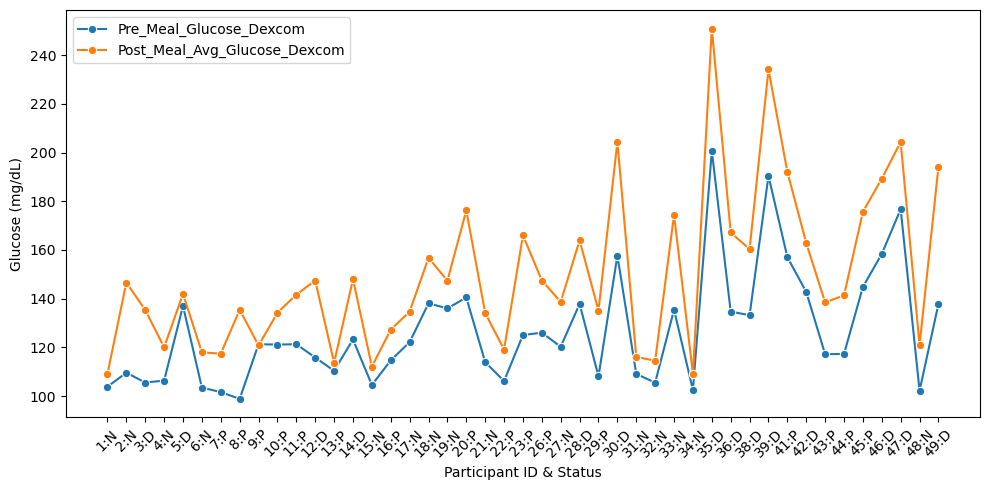

In [32]:
# Plot using label as x-axis
plt.figure(figsize=(10, 5))
sns.lineplot(data=melted_df2, x='label', y='Glucose', hue='Phase', marker='o', ci =None)

#plt.title('Pre- vs Post-Meal Glucose levels per Participant with Diabetes Status- Dexcom')
plt.xticks(rotation=45)
plt.ylabel('Glucose (mg/dL)')
plt.xlabel('Participant ID & Status')
plt.legend()
#plt.grid(True)
plt.tight_layout()
plt.show()

#### Dexcom - Insights:
- Post-meal glucose levels generally show a significant increase compared to pre-meal levels, with peaks exceeding 200 mg/dL for diabetic participants 30, 35 & 39(all diabetic) .
- This is expected, as diabetics often have impaired glucose regulation leading to higher postprandial spikes
- The pattern aligns with the Libre data, but some differences in magnitude of peaks suggest monitor-specific variations.
- Variability is high, with some normal (N) and prediabetic (P) participants also showing elevated post-meal levels, indicating potential early signs of glucose dysregulation.

#### Observing the average glucose changes for both the monitors 

In [35]:
glucose_change_df = pd.merge(glucose_change_df_libre, glucose_change_df_dexcom, on=['ParticipantID', 'Meal_Type','Meal_Time'])
glucose_change_df.head()

,ParticipantID,Meal_Type,Meal_Time,Pre_Meal_Glucose_libre,Post_Meal_Avg_Glucose_libre,Glucose_Change_libre,Pre_Meal_Glucose_Dexcom,Post_Meal_Avg_Glucose_Dexcom,Glucose_Change_Dexcom
0,1,Lunch,2020-05-01 14:23:00,69.8,82.250000,12.450000,109.4,115.516667,6.116667
1,1,Dinner,2020-05-01 20:48:00,84.8,98.390000,13.590000,114.8,126.658333,11.858333
2,1,Snack,2020-05-02 00:15:00,81.0,94.758333,13.758333,97.4,112.951667,15.551667
3,1,Breakfast,2020-05-02 08:18:00,88.4,98.753333,10.353333,101.8,109.675000,7.875000
4,1,Lunch,2020-05-02 12:00:00,82.0,89.608333,7.608333,80.0,87.961667,7.961667


In [36]:
#glucose_change_df.shape #(1661, 9)

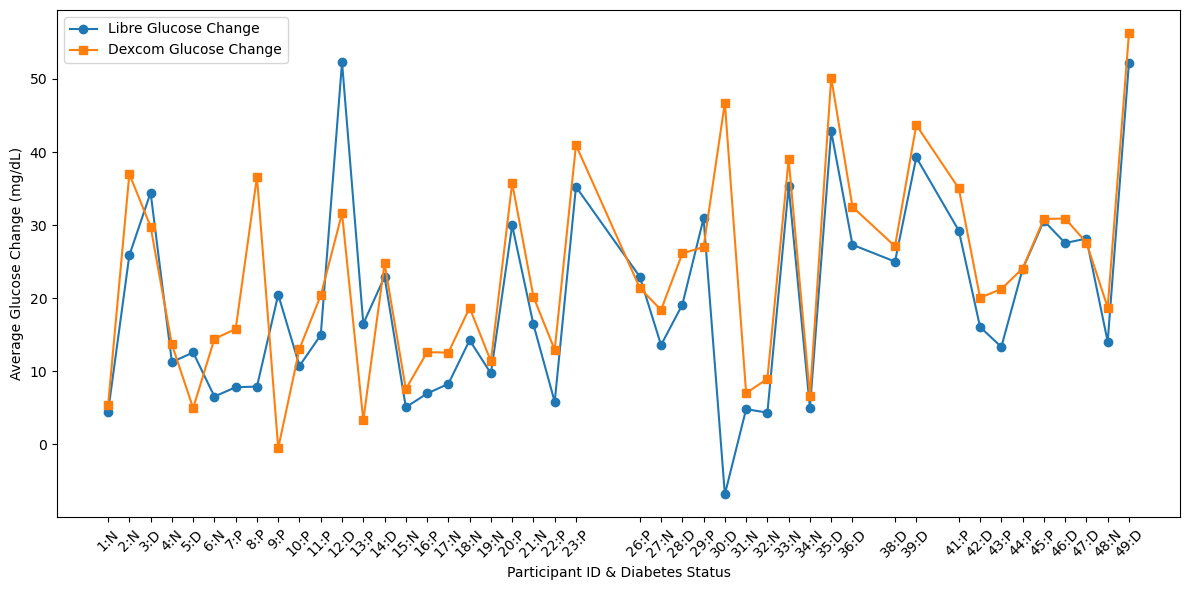

In [132]:
df2 = glucose_change_df

# Sort participant IDs for consistent x-axis
participant_ids = sorted(df2['ParticipantID'].unique())

# Calculate average or aggregate glucose change per participant
avg_changes = df2.groupby('ParticipantID')[['Glucose_Change_libre', 'Glucose_Change_Dexcom']].mean().reset_index()


# Assuming avg_changes has ParticipantID, and participant_df has ParticipantID and status
avg_changes = avg_changes.merge(participant_details_df[['ParticipantID','HbA1c_Classification']], on='ParticipantID')

# Create combined label
avg_changes['label'] = avg_changes['ParticipantID'].astype(str) + ':' + avg_changes['HbA1c_Classification'].str[0]

# Plot
plt.figure(figsize=(12,6))
plt.plot(avg_changes['ParticipantID'], avg_changes['Glucose_Change_libre'], marker='o', label='Libre Glucose Change')
plt.plot(avg_changes['ParticipantID'], avg_changes['Glucose_Change_Dexcom'], marker='s', label='Dexcom Glucose Change')

plt.xlabel('Participant ID & Diabetes Status')
plt.ylabel('Average Glucose Change (mg/dL)')
#plt.title('Average Glucose Change per Participant with Diabetes status for both monitors')
plt.xticks(ticks=avg_changes['ParticipantID'], labels=avg_changes['label'], rotation= 45)
plt.legend()
#plt.grid(True)
plt.tight_layout()
plt.show()


#### Insights:
- Most participants exhibit a positive glucose change (increase), with some diabetic participants (e.g., 12D, 35D, 39D, 49D) showing changes exceeding 30 mg/dL on both monitors.
- Negative changes are rare and mostly seen in normal participants, possibly due to measurement variability or post-meal activity.
- This reinforces the idea that individual physiology and behavior (e.g., meal composition, activity) play significant roles in glucose dynamics.

- General Observations:
  - Diabetic participants (D) consistently show the highest post-meal glucose levels and changes, reflecting impaired glucose regulation.
  - Prediabetic (P) participants exhibit intermediate responses, with some approaching diabetic levels, suggesting a progression risk.
  - Normal (N) participants generally maintain lower and more stable glucose levels, though outliers exist.
  - Differences between Dexcom and Libre monitors highlight potential variability in continuous glucose monitoring technology, which may affect clinical interpretations

In [39]:
# Merge datasets
df = pd.merge(merged_df, participant_details_df, on='ParticipantID', how='left')
df.head()
#df.shape #(687580,93)

,ParticipantID,Timestamp,Date,Time,Libre_GL,Dexcom_GL,Heart_Rate,Activity_Calories_Per_Minute,METs,Meal_Type,...,Sulfide_Gas_Production_Pathways_Desc,Oxalate_Metabolism_Pathways,Oxalate_Metabolism_Pathways_Desc,Salt_Stress_Pathways,Salt_Stress_Pathways_Desc,Microbiome_Induced_Stress,Microbiome_Induced_Stress_Desc,Good_Microbes_Count,Moderate_Microbes_Count,Bad_Microbes_Count
0,1,2020-05-01 10:30:00,2020-05-01,2020-05-01 10:30:00,84.00,106.83,56.0,1.05,10.0,NaN,...,Not Optimal,1.0,Not Optimal,3.0,Good,2.0,Average,87,435,15
1,1,2020-05-01 10:31:00,2020-05-01,2020-05-01 10:31:00,84.13,106.83,56.0,1.05,10.0,NaN,...,Not Optimal,1.0,Not Optimal,3.0,Good,2.0,Average,87,435,15
2,1,2020-05-01 10:32:00,2020-05-01,2020-05-01 10:32:00,84.27,106.83,57.0,1.05,10.0,NaN,...,Not Optimal,1.0,Not Optimal,3.0,Good,2.0,Average,87,435,15
3,1,2020-05-01 10:33:00,2020-05-01,2020-05-01 10:33:00,84.40,106.83,54.0,1.05,10.0,NaN,...,Not Optimal,1.0,Not Optimal,3.0,Good,2.0,Average,87,435,15
4,1,2020-05-01 10:34:00,2020-05-01,2020-05-01 10:34:00,84.53,106.83,55.0,1.05,10.0,NaN,...,Not Optimal,1.0,Not Optimal,3.0,Good,2.0,Average,87,435,15


#### METs vs. Glucose Levels

- Observing the impact of MET on glucose levels
- A Metabolic Equivalent of Task (MET) is a scientific unit that quantifies the energy cost of physical activities relative to resting metabolism.
- One MET is defined as the energy expenditure of sitting quietly, roughly equivalent to 3.5 milliliters of oxygen consumed per kilogram of body weight per minute (3.5 ml O2/kg/min).
- It is a way to compare how much harder your body is working during an activity compared to when you're at rest. 

<Figure size 1400x600 with 0 Axes>

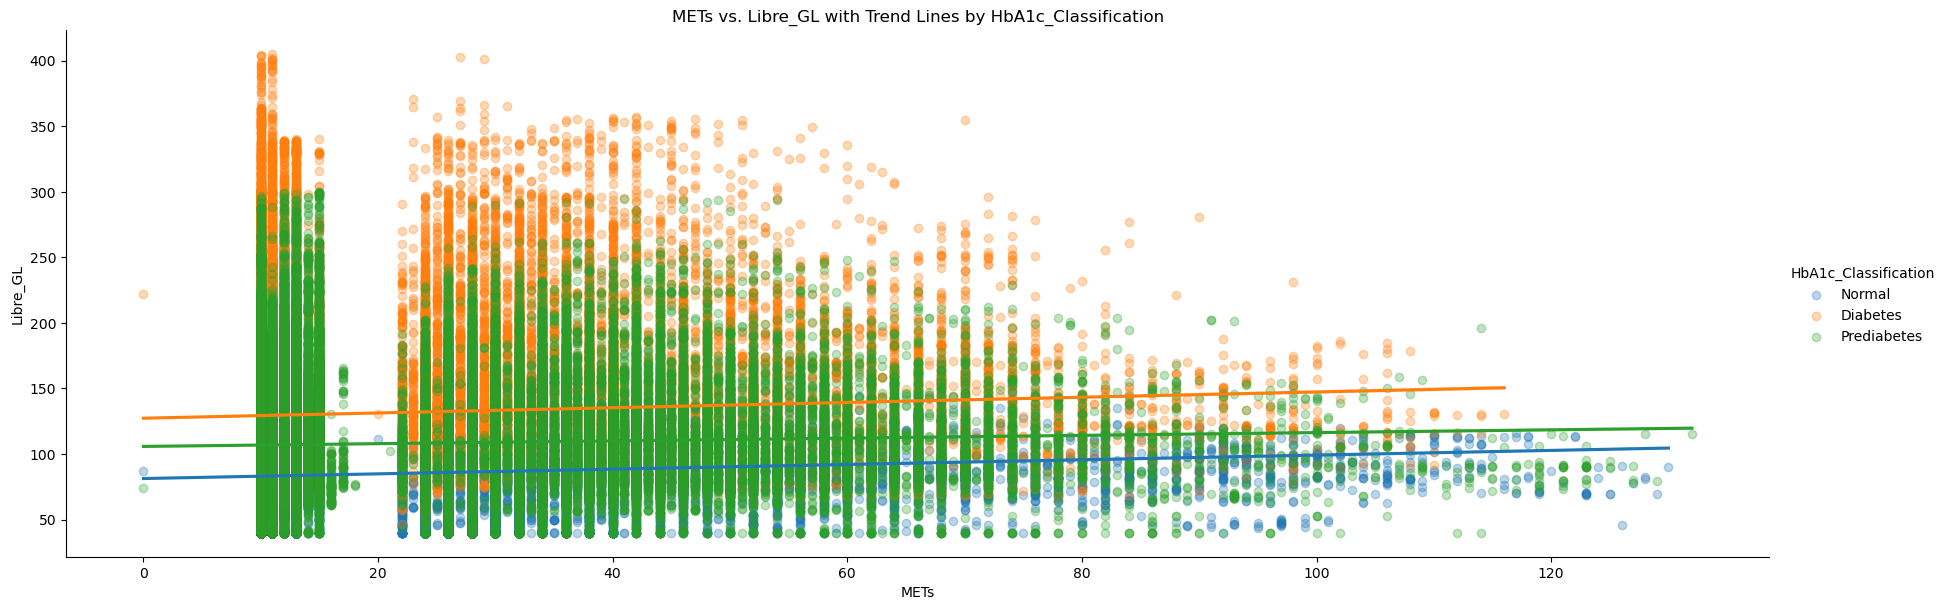

In [51]:
plt.figure(figsize=(14, 6))
# Create scatter plot with trend lines for each HbA1c_Classification
sns.lmplot(data=df, x='METs', y='Libre_GL', hue='HbA1c_Classification', height=6,  aspect= 3,  scatter_kws={'alpha': 0.3})
plt.title('METs vs. Libre_GL with Trend Lines by HbA1c_Classification')
plt.show()

<Figure size 1400x600 with 0 Axes>

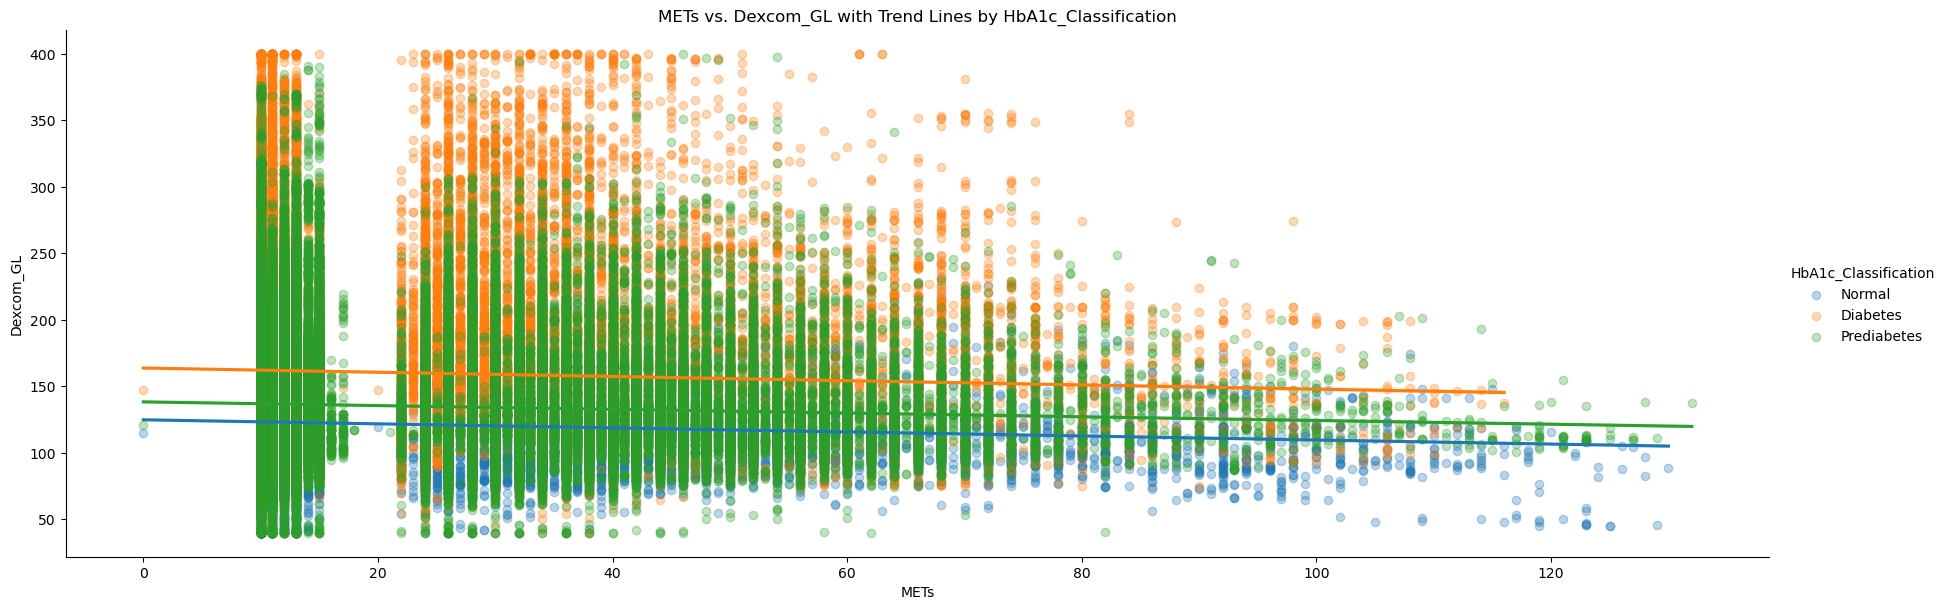

In [52]:
plt.figure(figsize=(14, 6))
# Create scatter plot with trend lines for each HbA1c_Classification
sns.lmplot(data=df, x='METs', y='Dexcom_GL', hue='HbA1c_Classification', height=6, aspect= 3,  scatter_kws={'alpha': 0.3})
plt.title('METs vs. Dexcom_GL with Trend Lines by HbA1c_Classification')
plt.show()

#### METs vs GLucose Levels Insights:
- Higher glucose levels (above 150 mg/dL) are predominantly associated with Diabetic (orange) and Prediabetic (green) classifications, while lower levels (below 100 mg/dL) are mostly Normal (blue). There is a general trend of decreasing glucose levels with increasing METs, suggesting that higher physical activity (higher METs) may correlate with better glucose control, particularly for Normal and Prediabetic individuals. A few Diabetic individuals show glucose levels below 100 mg/dL, and some Normal individuals exceed 150 mg/dL, indicating variability within classifications.

## Predictive Modeling using Machine Learning
- Multi-Output Regression predicts multiple target variables simultaneously. Here, we predict both Libre and Dexcom readings. This allows us to model potential correlation between the two targets.

- **Evaluation Metrics:**

  1. R2 Score (Coefficient of Determination): Measures goodness of fit
     - Formula: $R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$
     - R-squared (Coefficient of Determination) represents the proportion of variance in the dependent variable that is predictable from the independent variables.  
  3. MAE (Mean Absolute Error): Average of absolute differences.
     - Formula: $\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$                                     
  4. RMSE (Root Mean Squared Error): Square root of average squared differences.
     - Formula: $\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$
     - A lower RMSE indicates a better fit. High RMSE is due to model underfitting due to its simplicity  





In [48]:
# Import all regression models needed from scikit-learn 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
import time
# Import Light GBM and XGBoost
from lightgbm import LGBMRegressor
import xgboost as xgb

In [49]:
# Taking only some of the varibales from the dataset to be used in our model
subset_df = df[['ParticipantID','Timestamp','Heart_Rate', 'Activity_Calories_Per_Minute', 'METs',
       'Meal_Calories', 'Carbs', 'Protein', 'Fat', 'Fiber', 'Age', 'Gender',
       'BMI', 'Weight', 'Height', 'HbA1c','Fasting_Glucose',
       'Insulin', 'Triglycerides','Cholesterol', 'HDL', 'Non_HDL',
       'LDL_Calculated','VLDL_Calculated','Cho/HDL_Ratio_Calculated',
       'Gut_Lining_Health','Metabolic_Fitness','Gut_Microbiome_Health',
       'Good_Microbes_Count','Moderate_Microbes_Count', 'Bad_Microbes_Count']]

In [50]:
subset_df.head()

,ParticipantID,Timestamp,Heart_Rate,Activity_Calories_Per_Minute,METs,Meal_Calories,Carbs,Protein,Fat,Fiber,...,Non_HDL,LDL_Calculated,VLDL_Calculated,Cho/HDL_Ratio_Calculated,Gut_Lining_Health,Metabolic_Fitness,Gut_Microbiome_Health,Good_Microbes_Count,Moderate_Microbes_Count,Bad_Microbes_Count
0,1,2020-05-01 10:30:00,56.0,1.05,10.0,NaN,NaN,NaN,NaN,NaN,...,142,129,13,2.9,2.0,3.0,3.0,87,435,15
1,1,2020-05-01 10:31:00,56.0,1.05,10.0,NaN,NaN,NaN,NaN,NaN,...,142,129,13,2.9,2.0,3.0,3.0,87,435,15
2,1,2020-05-01 10:32:00,57.0,1.05,10.0,NaN,NaN,NaN,NaN,NaN,...,142,129,13,2.9,2.0,3.0,3.0,87,435,15
3,1,2020-05-01 10:33:00,54.0,1.05,10.0,NaN,NaN,NaN,NaN,NaN,...,142,129,13,2.9,2.0,3.0,3.0,87,435,15
4,1,2020-05-01 10:34:00,55.0,1.05,10.0,NaN,NaN,NaN,NaN,NaN,...,142,129,13,2.9,2.0,3.0,3.0,87,435,15


In [51]:
# Rename column in place in the subset dataframe, since we use it for merging with the glucose change dataframe
subset_df.rename(columns={'Timestamp': 'Meal_Time'}, inplace=True)

In [52]:
subset_df.head()

,ParticipantID,Meal_Time,Heart_Rate,Activity_Calories_Per_Minute,METs,Meal_Calories,Carbs,Protein,Fat,Fiber,...,Non_HDL,LDL_Calculated,VLDL_Calculated,Cho/HDL_Ratio_Calculated,Gut_Lining_Health,Metabolic_Fitness,Gut_Microbiome_Health,Good_Microbes_Count,Moderate_Microbes_Count,Bad_Microbes_Count
0,1,2020-05-01 10:30:00,56.0,1.05,10.0,NaN,NaN,NaN,NaN,NaN,...,142,129,13,2.9,2.0,3.0,3.0,87,435,15
1,1,2020-05-01 10:31:00,56.0,1.05,10.0,NaN,NaN,NaN,NaN,NaN,...,142,129,13,2.9,2.0,3.0,3.0,87,435,15
2,1,2020-05-01 10:32:00,57.0,1.05,10.0,NaN,NaN,NaN,NaN,NaN,...,142,129,13,2.9,2.0,3.0,3.0,87,435,15
3,1,2020-05-01 10:33:00,54.0,1.05,10.0,NaN,NaN,NaN,NaN,NaN,...,142,129,13,2.9,2.0,3.0,3.0,87,435,15
4,1,2020-05-01 10:34:00,55.0,1.05,10.0,NaN,NaN,NaN,NaN,NaN,...,142,129,13,2.9,2.0,3.0,3.0,87,435,15


In [53]:
# Merging the subset dataframe with the glucose change dataframe
modeling_df = pd.merge( glucose_change_df,subset_df,on = ['ParticipantID', 'Meal_Time'], how = 'left' )

In [54]:
#modeling_df.shape  #(1661, 38)

In [60]:
# We chose to remove Meal types, changes in glucose levels from the glucose change dataframe dataframe to keep only the relevant varibales needed for modeling
modeling_df.drop(columns=['Meal_Type','Glucose_Change_libre','Glucose_Change_Dexcom'], inplace= True)

In [64]:
#modeling_df.shape #(1661, 35)

In [66]:
# Check the data frame for missing entries
modeling_df.isnull().sum()

ParticipantID                     0
Meal_Time                         0
Pre_Meal_Glucose_libre            0
Post_Meal_Avg_Glucose_libre       0
Pre_Meal_Glucose_Dexcom           0
Post_Meal_Avg_Glucose_Dexcom      0
Heart_Rate                       80
Activity_Calories_Per_Minute     22
METs                            358
Meal_Calories                     0
Carbs                             0
Protein                           0
Fat                               0
Fiber                             1
Age                               0
Gender                            0
BMI                               0
Weight                            0
Height                            0
HbA1c                             0
Fasting_Glucose                   0
Insulin                           0
Triglycerides                     0
Cholesterol                       0
HDL                               0
Non_HDL                           0
LDL_Calculated                    0
VLDL_Calculated             

In [68]:
# The dataframe should be free from null values, so removing rows with nan vlaues
cleaned_model_df = modeling_df.dropna()
cleaned_model_df.shape

(1170, 35)

In [70]:
# The gender column has text based categorical values that needs to encoded into numbers to be handled by machine learning algorithms
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
le = LabelEncoder()

# Apply label encoding
cleaned_model_df['Gender'] = le.fit_transform(cleaned_model_df['Gender'])

In [72]:
# Separate the variables into target and input variables
targets = ['Post_Meal_Avg_Glucose_libre', 'Post_Meal_Avg_Glucose_Dexcom'] 

# Taking a subset of features related to demographics('Age','Gender', 'BMI', 'Weight', 'Height'), lab values/vitals, meal composition, activity levels, 
# gut health, microbes countfrom each of the cleaned datasets based on domain knowledge 
input_variables = ['Pre_Meal_Glucose_libre','Pre_Meal_Glucose_Dexcom', 
                   'Heart_Rate', 'Activity_Calories_Per_Minute', 'METs' , 
                   'Meal_Calories', 'Carbs', 'Protein', 'Fat', 'Fiber', 
                   'Age','Gender', 'BMI', 'Weight', 'Height','HbA1c',
                   'Fasting_Glucose', 'Insulin', 'Triglycerides', 'Cholesterol', 'HDL',
                   'Non_HDL', 'LDL_Calculated', 'VLDL_Calculated',
                   'Cho/HDL_Ratio_Calculated', 'Gut_Lining_Health', 'Metabolic_Fitness',
                   'Gut_Microbiome_Health', 'Good_Microbes_Count',
                   'Moderate_Microbes_Count', 'Bad_Microbes_Count']

In [74]:
#Store the selected featires and targets into X and  y variables
X = cleaned_model_df[input_variables]
y =  cleaned_model_df[targets]
print(X.shape)
print(y.shape)

(1170, 31)
(1170, 2)


In [76]:
# Train-test split the data into 90 (train data) and 10(test data) ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.1, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1053, 31)
(1053, 2)
(117, 31)
(117, 2)


### Feature Importance 
 - Feature Importance refers to a measure of how much each input feature (variable) contributes to the predictive performance of a machine learning model. It quantifies the impact of a feature on the model's output, helping to identify which variables are most influential in making predictions.

- There are many ways to use feature importance.
  
  **1. Feature importance using Correlation:**
    - Strong correlations between input and output variables indicate which features are most predictive of the target. This helps in selecting relevant features, reducing model complexity, and improving performance by eliminating irrelevant or redundant variables.
    - Understanding correlations provides insights into how input variables influence the output. This makes models more interpretable, especially in healthcare domains where explaining predictions is important.
    - Highly correlated features can enhance model accuracy, as they provide meaningful patterns for the algorithm to learn. Conversely, identifying weakly correlated features can prevent the model from learning noise.

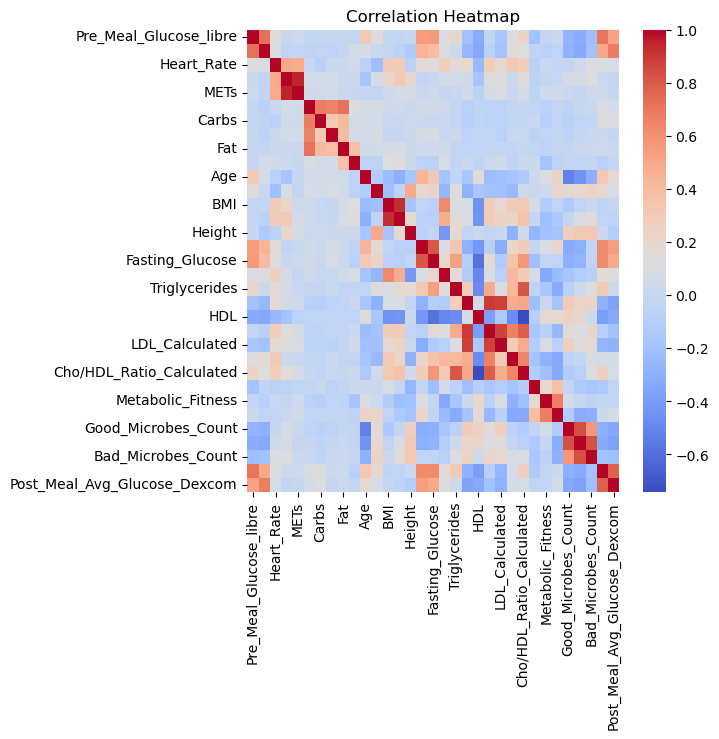

In [79]:
# Visualizing the Correlation with targets using heatmap
correlations = X_train.join(y_train).corr()
#print(correlations['Post_Meal_Avg_Glucose_libre'].sort_values(ascending=False))
#print("-----------------------------------------------------")
#print(correlations['Post_Meal_Avg_Glucose_Dexcom'].sort_values(ascending=False))

# Plot heatmap
plt.figure(figsize=(6,6))
sns.heatmap(correlations,annot=False, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

#### Insights:
 1. Strong Correlations: (0.6 to 1.0)
    - Fasting_Glucose and Post_Meal_Avg_Glucose_Dexcom also exhibit a strong positive correlation, indicating a consistent relationship between fasting and post-meal glucose levels.
    - Triglycerides and LDL_Calculated show a moderate to strong positive correlation, which is expected as both are lipid-related markers often associated with metabolic health.

 2. Strong Negative Correlations: (-0.6 to -1.0)
    - Good_Microbes_Count and Bad_Microbes_Count have a strong negative correlation, implying an inverse relationship where higher counts of beneficial microbes are associated with lower counts of harmful microbes.
    - Metabolic_Fitness and Bad_Microbes_Count show a moderate negative correlation, suggesting that better metabolic fitness is linked to lower levels of harmful microbes.(highlighting the potential role of microbial balance in fitness)

 3. Moderate Correlations ( 0.2 to 0.6 or -0.2 to -0.6):
    - BMI and Fasting_Glucose have a moderate positive correlation, indicating that higher BMI may be associated with elevated fasting glucose levels.
    - Age and Chol/HDL_Ratio_Calculated show a moderate positive correlation, suggesting that cholesterol ratios may increase with age.
   
 4. Weak Correlations (-0.2 to 0.2):
    - Height and several variables (e.g., METs, Fat) show weak to no correlation (light colors), indicating height may not be a strong predictor for these metabolic markers.
    - Variables like Heart_Rate and Height with Good_Microbes_Count or Bad_Microbes_Count show weak or no correlation, suggesting these factors may not be strongly related to microbial counts.
    - Carbs and HDL also appear to have minimal correlation, indicating carbohydrate intake may not directly influence HDL levels.

#### **2. Recursive feature elimination (RFE)** 

- Recursive Feature Elimination (RFE) is a feature selection method available in scikit-learn.
- This helps to identify top predictors and reduce noise, to improve model performance.
- It works by recursively removing features, starting with all features and iteratively discarding the least important ones based on a chosen model's feature importance, until the desired number of features is reached. 



In [83]:
# Recursive Feature Elimination (RFE)
base_model = LinearRegression()
rfe = RFE(base_model, n_features_to_select=10)    # desired number of features to select is 10
rfe.fit(X_train, y_train['Post_Meal_Avg_Glucose_libre'])

# Selected features
selected_features = X_train.columns[rfe.support_]
# We can see the top 10 featues that the base model used
print("Selected features:", selected_features)

Selected features: Index(['Gender', 'HbA1c', 'Cholesterol', 'HDL', 'Non_HDL', 'LDL_Calculated',
       'VLDL_Calculated', 'Gut_Lining_Health', 'Metabolic_Fitness',
       'Gut_Microbiome_Health'],
      dtype='object')


#### **3. Built-in Feature Importance:** 
- Random Forest Regressor model does have a built-in method for assessing feature importance. 

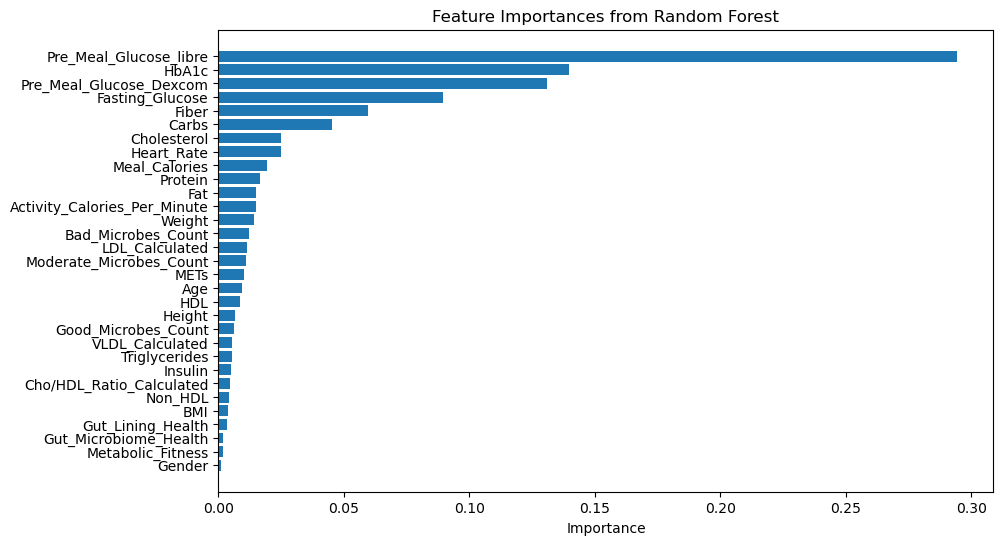

In [86]:
# Fit random forest on training data
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_names = X_train.columns

# Sort features and importances
sorted_idx = importances.argsort()  #[::-1] 
sorted_features = feature_names[sorted_idx]
sorted_importances = importances[sorted_idx]
# Plot
plt.figure(figsize=(10,6))
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.show()

#### Implementing the same built-in feature importance with the LightGBM model

In [89]:
mo_lgbmr = MultiOutputRegressor(LGBMRegressor())
# Fit and predict
mo_lgbmr.fit(X_train, y_train)
y_pred = mo_lgbmr.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1690
[LightGBM] [Info] Number of data points in the train set: 1053, number of used features: 31
[LightGBM] [Info] Start training from score 119.020510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1690
[LightGBM] [Info] Number of data points in the train set: 1053, number of used features: 31
[LightGBM] [Info] Start training from score 145.783392


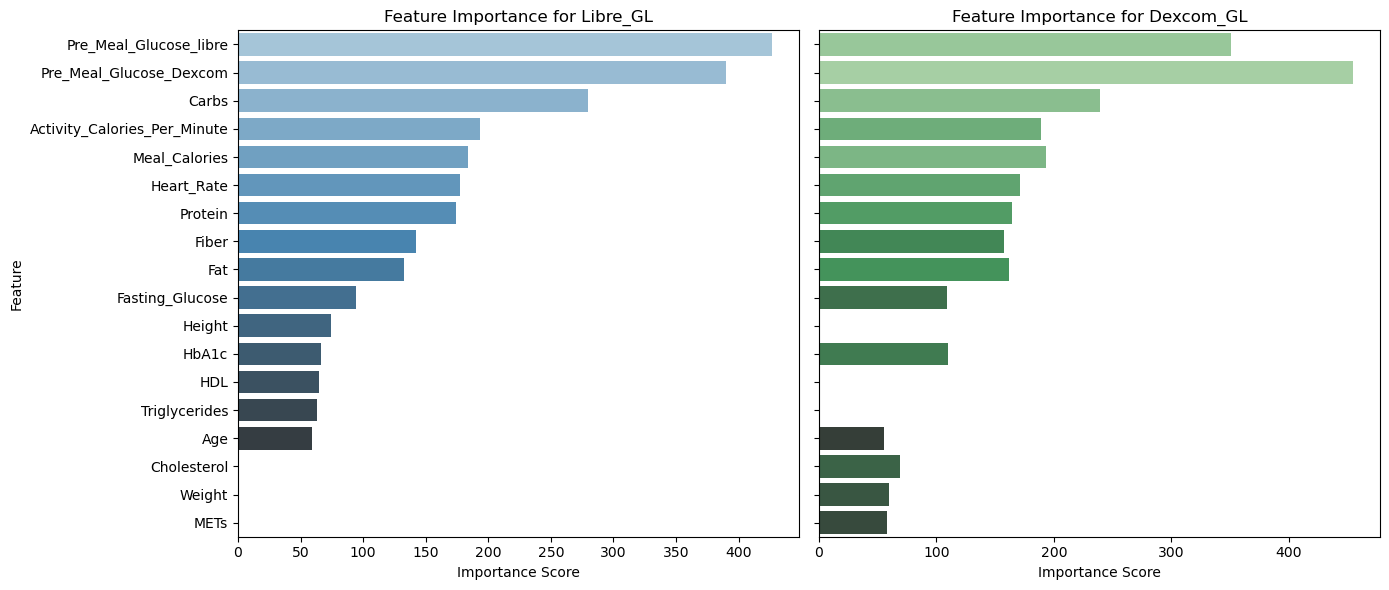

In [91]:
# Access individual LightGBM models from the multi-output wrapper
libre_model = mo_lgbmr.estimators_[0]
dexcom_model = mo_lgbmr.estimators_[1]

# Get feature names from preprocessing pipeline
feature_names = input_variables
# Get importance scores from LightGBM models
libre_importances = libre_model.feature_importances_
dexcom_importances = dexcom_model.feature_importances_

# Convert to DataFrames
libre_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': libre_importances})
dexcom_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': dexcom_importances})

# Sort by importance
libre_imp_df = libre_imp_df.sort_values(by='Importance', ascending=False).head(15)
dexcom_imp_df = dexcom_imp_df.sort_values(by='Importance', ascending=False).head(15)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.barplot(data=libre_imp_df, x='Importance', y='Feature', ax=axs[0], palette='Blues_d')
axs[0].set_title('Feature Importance for Libre_GL')
axs[0].set_xlabel('Importance Score')

sns.barplot(data=dexcom_imp_df, x='Importance', y='Feature', ax=axs[1], palette='Greens_d')
axs[1].set_title('Feature Importance for Dexcom_GL')
axs[1].set_xlabel('Importance Score')

plt.tight_layout()
plt.show()

### **Model building and Evaluation**

- **1. Linear Regression:** 
  - A Foundational and widely used technique, especially for regression tasks. Its simplicity, interpretability, and efficiency make it a great starting point and a valuable tool in various applications. While other models exist for more complex relationships, linear regression provides a solid base for understanding fundamental concepts and can be surprisingly effective in many scenarios.


- **2. K-Nearest Neighbors:**
  - KNN is a non-parametric algorithm that predicts glucose responses by averaging the values of the $ k $ nearest data points (based on feature similarity, e.g., Euclidean distance, Manhattan distance) in the training set. For multi-output, it applies the same logic to each output variable independently.


- **3. Random Forest:**
  - Random Forest is an ensemble method that builds multiple decision trees on random subsets of data and features, then averages their predictions for each output (glucose response). Each tree splits data based on feature thresholds to minimize variance.It handles non-linear relationships and feature interactions well, making it robust for complex glucose response patterns. It reduces overfitting compared to single trees but can be computationally intensive.


- **4. XGBoost:**
  - XGBoost is an ensemble boosting algorithm that sequentially builds decision trees, where each tree corrects errors of the previous ones by optimizing a loss function (e.g., mean squared error) with gradient descent. For multi-output, it can optimize a combined loss across outputs. It excels in capturing complex, non-linear glucose response patterns with high accuracy. Regularization prevents overfitting, and it’s efficient but requires careful hyperparameter tuning.
    

- **5. Multi-Output Light GBM:**
  - In scikit-learn, a MultiOutput regression model is used when you need to predict multiple continuous target variables simultaneously for each input sample. Instead of predicting a single value, it allows you to model relationships between input features and multiple output variables. Since LightGBM cannot predict 2 target variables at once, we wrap it with multi-output regressor.
  - LightGBM is a gradient boosting framework similar to XGBoost but optimized for speed and memory efficiency using histogram-based learning and leaf-wise tree growth. It handles multi-output regression by fitting trees to minimize a loss function across all outputs.It’s highly efficient for large datasets and complex glucose response patterns, capturing non-linearities and interactions. It’s faster than XGBoost but may overfit on small datasets without proper tuning.
  

In [99]:
# Train and evaluate different regression models 

def train_and_test_models(X_train, X_test, y_train, y_test):
    
    # Initialize different regression models (base models)
    models = [
        ("Linear Regression", LinearRegression()),
        ("K-Nearest Neighbors", KNeighborsRegressor()), 
        ("Random Forest", RandomForestRegressor()),
        ("XGBoost" , MultiOutputRegressor(xgb.XGBRegressor())),
        ("LightGBM",  MultiOutputRegressor(LGBMRegressor()))  #n_estimators=100, learning_rate=0.1, random_state=42
       ]
    
    # Create lists to store the results
    model_names = []
    r2_tr_values = []
    mse_tr_values = []    
    rmse_tr_values=[]
    mae_tr_values = []
    r2_te_values = []
    mse_te_values = []    
    rmse_te_values=[]
    mae_te_values = []
           
    # Fit and evaluate each model
    for model_name, model in models:
        
        # fit model on train data
        model.fit(X_train, y_train)
        
        #predict on train data
        y_pred_tr = model.predict(X_train)
        
        # compute performance scores of train set
        r2_tr = r2_score(y_train, y_pred_tr)
        mse_tr = mean_squared_error(y_train, y_pred_tr)
        rmse_tr = np.sqrt(mse_tr)
        mae_tr = mean_absolute_error(y_train, y_pred_tr)
            
        #predict on test data
        y_pred = model.predict(X_test)            
        
        # compute performance scores of test set
        r2_te = r2_score(y_test, y_pred)
        mse_te = mean_squared_error(y_test, y_pred)
        rmse_te = np.sqrt(mse_te)
        mae_te = mean_absolute_error(y_test, y_pred)
               
        # Append the train values
        model_names.append(model_name)
        r2_tr_values.append(r2_tr)
        mse_tr_values.append(mse_tr)   
        rmse_tr_values.append(rmse_tr)
        mae_tr_values.append(mae_tr)
        
        # Append the train values
        r2_te_values.append(r2_te)
        mse_te_values.append(mse_te)       
        rmse_te_values.append(rmse_te)
        mae_te_values.append(mae_te)
        
        
        # Create a Dataframe       
        metrics_df=pd.DataFrame({
            'Model': model_names,
            
            'R2_train' :np.round(r2_tr_values,2),
            #'MSE_train': np.round(mse_tr_values,2),
            #'RMSE_train': np.round(rmse_tr_values,2),
            #'MAE_train': np.round(mae_tr_values,2),
            
            'R2_test': np.round(r2_te_values,2),            
            #'MSE_test': np.round(mse_te_values,2),
            'RMSE_test': np.round(rmse_te_values,2),
            'MAE_test': np.round(mae_te_values,2)
            
        })
    return metrics_df

In [101]:
train_and_test_models(X_train,X_test,y_train,y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1690
[LightGBM] [Info] Number of data points in the train set: 1053, number of used features: 31
[LightGBM] [Info] Start training from score 119.020510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1690
[LightGBM] [Info] Number of data points in the train set: 1053, number of used features: 31
[LightGBM] [Info] Start training from score 145.783392


,Model,R2_train,R2_test,RMSE_test,MAE_test
0,Linear Regression,0.65,0.62,22.54,16.32
1,K-Nearest Neighbors,0.72,0.46,26.87,21.28
2,Random Forest,0.97,0.78,16.97,12.76
3,XGBoost,1.00,0.77,17.48,12.59
4,LightGBM,0.97,0.78,16.99,12.43


#### Insights:
- Linear Regression : A decent baseline with moderate accuracy. Slight underfitting likely due to its simplicity and struggles with non-linear patterns due to its simplicity.
- K-Nearest Neighbors : Overfitting, performs better on training than testing. May be sensitive to noise and not generalizing well.
- Random Forest: Showed strong performance with low error and good generalization. Robust and less prone to overfitting.
- XGBoost : Slightly overfitting, has perfect train score but lower test performance. Still very competitive.
- LightGBM : Best model overall with balanced high R², lowest test error, and excellent generalization. 

#### Hyperparameter Tuning
- It adjusts model parameters (like tree depth, learning rate) to improve performance. We used grid search with cross-validation to find the best combination.
-  Since LightGBM and Random Forest Models performed good, we performed hyper parameter tuning to these models to improve model performance.

In [103]:
# Random Forest regressor
model_rf = RandomForestRegressor(random_state=42)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(model_rf, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best R2 Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best R2 Score: 0.7322912358912514


In [104]:
#LigthGBM
from sklearn.model_selection import GridSearchCV
#import lightgbm as lgb

# Create LightGBM regressor
model_lgb =  MultiOutputRegressor(LGBMRegressor())
#MultiOutputRegressor(LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
# Define parameter grid
param_grid = {
    'estimator__num_leaves': [31, 50, 70],
    'estimator__max_depth': [5, 10, 15],
    'estimator__learning_rate': [0.05, 0.1, 0.2],
    'estimator__n_estimators': [100, 200, 500] }

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(model_lgb, param_grid, cv=5,scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best R2 Score:", grid_search.best_score_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1690
[LightGBM] [Info] Number of data points in the train set: 1053, number of used features: 31
[LightGBM] [Info] Start training from score 119.020510
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [105]:
# Train and evaluate Random Forerst & Light GBM regression models 
# using the best parameters we got from Hyper parameter tuning
def train_and_test_models(X_train, X_test, y_train, y_test):
    # Initialize different regression models
    models = [
        ("Random Forest", RandomForestRegressor(max_depth=20, max_features='sqrt',
                                                min_samples_leaf=1, min_samples_split=2, n_estimators=500)),
        ("LightGBM",  MultiOutputRegressor(LGBMRegressor(estimator__learning_rate=0.05, estimator__max_depth=5, 
                                                         estimator__n_estimators=200, estimator__num_leaves= 31)))
       ]    
    # Create lists to store the results
    model_names = []
    r2_tr_values = []
    mse_tr_values = []    
    rmse_tr_values=[]
    mae_tr_values = []
    r2_te_values = []
    mse_te_values = []    
    rmse_te_values=[]
    mae_te_values = []
           
    # Fit and evaluate each model
    for model_name, model in models:
        
        # fit model on train data
        model.fit(X_train, y_train)
        
        #predict on train data
        y_pred_tr = model.predict(X_train)
        
        # compute performance scores of train set
        r2_tr = r2_score(y_train, y_pred_tr)
        mse_tr = mean_squared_error(y_train, y_pred_tr)
        rmse_tr = np.sqrt(mse_tr)
        mae_tr = mean_absolute_error(y_train, y_pred_tr)
            
        #predict on test data
        y_pred = model.predict(X_test)            
        
        # compute performance scores of test set
        r2_te = r2_score(y_test, y_pred)
        mse_te = mean_squared_error(y_test, y_pred)
        rmse_te = np.sqrt(mse_te)
        mae_te = mean_absolute_error(y_test, y_pred)
               
        # Append the train values
        model_names.append(model_name)
        r2_tr_values.append(r2_tr)
        mse_tr_values.append(mse_tr)   
        rmse_tr_values.append(rmse_tr)
        mae_tr_values.append(mae_tr)
        
        # Append the train values
        r2_te_values.append(r2_te)
        mse_te_values.append(mse_te)       
        rmse_te_values.append(rmse_te)
        mae_te_values.append(mae_te)
                
        # Create a Dataframe       
        metrics_df=pd.DataFrame({
            'Model': model_names,
            
            'R2_train' :np.round(r2_tr_values,2),
            #'MSE_train': np.round(mse_tr_values,2),
            #'RMSE_train': np.round(rmse_tr_values,2),
            #'MAE_train': np.round(mae_tr_values,2),
            
            'R2_test': np.round(r2_te_values,2),            
            #'MSE_test': np.round(mse_te_values,2),
            'RMSE_test': np.round(rmse_te_values,2),
            'MAE_test': np.round(mae_te_values,2)
            
        })
    return metrics_df

In [106]:
train_and_test_models(X_train,X_test,y_train,y_test)

[LightGBM] [Warning] Unknown parameter: estimator__max_depth
[LightGBM] [Warning] Unknown parameter: estimator__n_estimators
[LightGBM] [Warning] Unknown parameter: estimator__learning_rate
[LightGBM] [Warning] Unknown parameter: estimator__num_leaves
[LightGBM] [Warning] Unknown parameter: estimator__max_depth
[LightGBM] [Warning] Unknown parameter: estimator__n_estimators
[LightGBM] [Warning] Unknown parameter: estimator__learning_rate
[LightGBM] [Warning] Unknown parameter: estimator__num_leaves
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1690
[LightGBM] [Info] Number of data points in the train set: 1053, number of used features: 31
[LightGBM] [Info] Start training from score 119.020510
[LightGBM] [Warning] Unknown parameter: estimator__max_depth
[LightGBM] [Warning] Unknown parameter: estimator__n_estimators
[LightGBM] [Warning] Unknown

,Model,R2_train,R2_test,RMSE_test,MAE_test
0,Random Forest,0.97,0.75,18.16,13.85
1,LightGBM,0.97,0.78,16.99,12.43


#### Final Model Building & Results
- After testing various regression models, and applying Hyper parameter Tuning,  LightGBM delivered the best performance with an R² of 0.78, the lowest RMSE (16.99), and MAE (12.43) on the test set. Random Forest also performed well with R² scores above 0.75.
- Although hyperparameter tuning was applied to LightGBM and Random Forest models, their performance did not significantly improve beyond the base configurations.
- This suggests that the base models were already near-optimal given the available data, and further tuning yielded diminishing returns.


### **Key Insights/Conclusions:**
  - Machine learning models can reveal patterns and improve predictions.
  - Feature selection and preprocessing  are critical for all models. 
  - **Linear Regression** is best for simple, linear relationships but may underperform with complex glucose dynamics.
  - **kNN** captures local patterns without model assumptions, suitable for irregular glucose trends. But Poor test R² and highest error metrics suggest it's not the best fit.
  - **Random Forest**, **XGBoost**, and **LightGBM** excel in modeling non-linear, complex relationships in glucose data, with XGBoost and LightGBM offering higher accuracy and efficiency but requiring more tuning.
  - All can handle multi-output prediction by treating each glucose response as a separate target or optimizing a joint loss, depending on the implementation.
  - Overall, LightGBM was chosen as the final model due to its strong predictive accuracy, generalization capability, and computational efficiency.    
  - **Challenges** include potential overfitting, needing enough quality data, and interpreting complex models.